# GOAL OF OUR PROJECT:
To identify all customers who are at risk of leaving (churners), so that the company can act (e.g., offer discounts, call them, give loyalty rewards).

# We will be focusing on maximising our Recall rate in this project..Why?
Think of churn prediction like security at an airport:

It's better to flag a few innocent people (low precision)

Than to miss an actual threat (low recall)

Similarly, it's better to reach out to 100 people, even if only 50 would have left — rather than missing 20 who silently leave and take their money with them.

# What is Recall?
Recall = TP / (TP + FN)
→ Of all actual churners, how many did we correctly predict?

If recall is low, you’re missing many real churners, which is very costly for a business.

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('Bank Customer Churn Prediction.csv')

In [4]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.value_counts('churn')

churn
0    7963
1    2037
Name: count, dtype: int64

# Lets drop columns which does make any affect on Churn rate

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [8]:
categories_rows = ["country", "gender", "active_member", "credit_card"]
numeric_rows = ["credit_score", "age", "tenure", "balance", "products_number", "estimated_salary"]

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

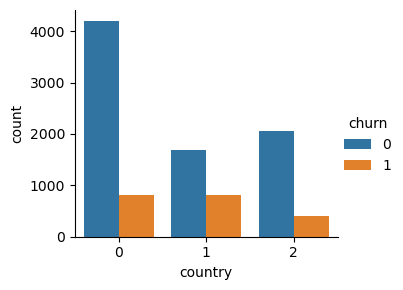

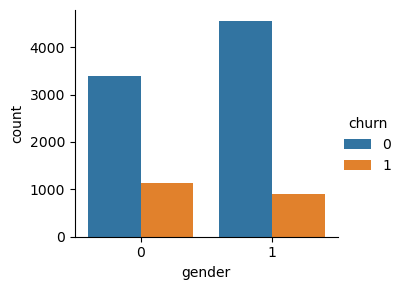

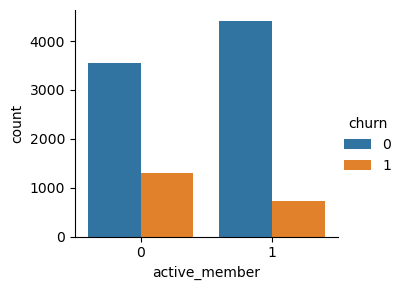

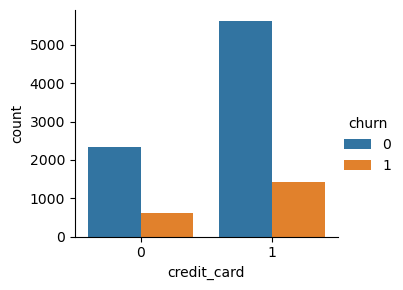

In [ ]:
for col in categories_rows:
    g = sns.catplot(
        data=df, kind="count", x=col, hue="churn",
        height=3, aspect=1.2  # smaller plot size
    )
    g.set_xticklabels(rotation=30)

In [11]:
df.drop(columns=["customer_id"], inplace=True)

In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
categories = ["country","gender"]
le_dict = {}
for col in categories:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

In [18]:
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,salary_bucket
0,619,0,0,42,2,0.00,1,1,1,101348.88,1,1L–1.2L
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0,1L–1.2L
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1,1L–1.2L
3,699,0,0,39,1,0.00,2,0,0,93826.63,0,80K–1L
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0,60K–80K


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [23]:
df.drop(columns=["salary_bucket"], inplace=True)

In [24]:
X = df.drop(columns=["churn"])
y = df["churn"]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42, stratify=y,shuffle=True)

In [26]:
scaler = StandardScaler()

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGB Classifier

In [29]:
from xgboost import XGBClassifier

In [85]:
model = XGBClassifier()

In [86]:
# Define scale_pos_weight for imbalance handling
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

In [ ]:
# Param grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [scale_pos_weight] 
}


In [90]:
# Grid search
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=0,
    n_jobs=1
)

In [91]:
grid.fit(X_train_scaled, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5], 'n_estimators': [100, 200], ...}"
,scoring,'f1'
,n_jobs,1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [92]:
predictions = grid.predict(X_test_scaled)

In [93]:
from sklearn.metrics import classification_report, confusion_matrix

In [94]:
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      2628
           1       0.51      0.75      0.61       672

    accuracy                           0.80      3300
   macro avg       0.72      0.78      0.74      3300
weighted avg       0.84      0.80      0.82      3300



# SUPPORT VECTOR CLASSIFIER

In [35]:
from sklearn.svm import SVC

In [36]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'C': [0.5, 1, 2, 5],               # Regularization parameter
    'gamma': [1,0.05, 0.1],          # Controls the influence of a single training example
    'kernel': ['rbf'],
    'class_weight': ['balanced'] #Forced attention to minority class (churners)
}


grid = GridSearchCV(
    estimator=SVC(probability=True),
    param_grid=param_grid,
    scoring='f1',       # Optimizing for f1-score
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)
print("Best parameters:", grid.best_params_)

y_pred = grid.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      2628
           1       0.48      0.75      0.59       672

    accuracy                           0.79      3300
   macro avg       0.70      0.77      0.72      3300
weighted avg       0.84      0.79      0.80      3300

